In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import pickle
import gzip
from math import exp
import operator
import graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

from pathlib import Path
from collections import Counter

In [3]:
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [33]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

In [5]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('./Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100

# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

loan_amnt  int_rate  installment home_ownership  annual_inc  \
0    10500.0    0.1719       375.35           RENT     66000.0   
1    25000.0    0.2000       929.09       MORTGAGE    105000.0   
2    20000.0    0.2000       529.88       MORTGAGE     56000.0   
3    10000.0    0.1640       353.55           RENT     92000.0   
4    22000.0    0.1474       520.39       MORTGAGE     52000.0   

  verification_status   issue_d loan_status pymnt_plan    dti  ...  \
0     Source Verified  Mar-2019    low_risk          n  27.24  ...   
1            Verified  Mar-2019    low_risk          n  20.23  ...   
2            Verified  Mar-2019    low_risk          n  24.26  ...   
3            Verified  Mar-2019    low_risk          n  31.44  ...   
4        Not Verified  Mar-2019    low_risk          n  18.76  ...   

   pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
0            85.7             100.0                   0.0        0.0   
1            91.2              50.0                   1.0        0.0   
2            66.7              50.0                   0.0        0.0   
3           100.0              50.0                   1.0        0.0   
4           100.0               0.0                   0.0        0.0   

   tot_hi_cred_lim  total_bal_ex_mort total_bc_limit  \
0          65687.0            38199.0         2000.0   
1         271427.0            60641.0        41200.0   
2          60644.0            45684.0         7500.0   
3          99506.0            68784.0        19700.0   
4         219750.0            25919.0        27600.0   

   total_il_high_credit_limit  hardship_flag  debt_settlement_flag  
0                     61987.0              N                     N  
1                     49197.0              N                     N  
2                     43144.0              N                     N  
3                     76506.0              N                     N  
4                     20000.0              N                     N  

[5 rows x 86 columns]

In [7]:
df['loan_status'].unique()
df['loan_status'] = df['loan_status'].map({'low_risk': 0, 'high_risk': 1})
df['loan_status'].describe()

count    68817.000000
mean         0.005042
std          0.070831
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64

In [92]:
# features
X = df.copy()  # YOUR CODE HERE

# using get dummies to convert string to numerical values
X = pd.get_dummies(data=X, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', \
                                   'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag'])

X.rename(columns={'verification_status_Not Verified': 'verification_status_Not_Verified', 
                  'verification_status_Source Verified': 'verification_status_Source_Verified',}, 
         inplace=True)

fcol = X.pop('loan_status')
X.insert(0, 'loan_status', fcol)
X1 = X.copy()
X2 = X.copy()
X = X.drop(columns='loan_status', axis=1)

# target
y = df['loan_status']

In [9]:
X.describe()

loan_amnt      int_rate   installment    annual_inc           dti  \
count  68817.000000  68817.000000  68817.000000  6.881700e+04  68817.000000   
mean   16677.594562      0.127718    480.652863  8.821371e+04     21.778153   
std    10277.348590      0.048130    288.062432  1.155800e+05     20.199244   
min     1000.000000      0.060000     30.890000  4.000000e+01      0.000000   
25%     9000.000000      0.088100    265.730000  5.000000e+04     13.890000   
50%    15000.000000      0.118000    404.560000  7.300000e+04     19.760000   
75%    24000.000000      0.155700    648.100000  1.040000e+05     26.660000   
max    40000.000000      0.308400   1676.230000  8.797500e+06    999.000000   

        delinq_2yrs  inq_last_6mths      open_acc       pub_rec  \
count  68817.000000    68817.000000  68817.000000  68817.000000   
mean       0.217766        0.497697     12.587340      0.126030   
std        0.718367        0.758122      6.022869      0.336797   
min        0.000000        0.000000      2.000000      0.000000   
25%        0.000000        0.000000      8.000000      0.000000   
50%        0.000000        0.000000     11.000000      0.000000   
75%        0.000000        1.000000     16.000000      0.000000   
max       18.000000        5.000000     72.000000      4.000000   

           revol_bal  ...  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
count   68817.000000  ...        68817.000000        68817.000000   
mean    17604.142828  ...            0.052138            2.219423   
std     21835.880400  ...            0.390633            1.897432   
min         0.000000  ...            0.000000            0.000000   
25%      6293.000000  ...            0.000000            1.000000   
50%     12068.000000  ...            0.000000            2.000000   
75%     21735.000000  ...            0.000000            3.000000   
max    587191.000000  ...           18.000000           19.000000   

       pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
count    68817.000000      68817.000000          68817.000000    68817.0   
mean        95.057627         30.626217              0.125972        0.0   
std          8.326426         33.631463              0.336732        0.0   
min         20.000000          0.000000              0.000000        0.0   
25%         93.000000          0.000000              0.000000        0.0   
50%        100.000000         20.000000              0.000000        0.0   
75%        100.000000         50.000000              0.000000        0.0   
max        100.000000        100.000000              4.000000        0.0   

       tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
count     6.881700e+04       6.881700e+04    68817.000000   
mean      2.100332e+05       6.133843e+04    29734.128558   
std       1.928088e+05       5.738798e+04    26795.394232   
min       3.600000e+03       2.350000e+02      100.000000   
25%       6.697700e+04       2.650300e+04    11600.000000   
50%       1.467100e+05       4.535700e+04    22100.000000   
75%       3.036400e+05       7.657000e+04    39300.000000   
max       3.292782e+06       1.295455e+06   509400.000000   

       total_il_high_credit_limit  
count                6.881700e+04  
mean                 5.572240e+04  
std                  5.095845e+04  
min                  1.270000e+02  
25%                  2.288000e+04  
50%                  4.200000e+04  
75%                  7.249900e+04  
max                  1.426964e+06  

[8 rows x 76 columns]

In [10]:
y.value_counts()

loan_status
0    68470
1      347
Name: count, dtype: int64

In [11]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(51612, 95)
(17205, 95)
(51612,)
(17205,)


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 95 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            68817 non-null  float64
 1   int_rate                             68817 non-null  float64
 2   installment                          68817 non-null  float64
 3   annual_inc                           68817 non-null  float64
 4   dti                                  68817 non-null  float64
 5   delinq_2yrs                          68817 non-null  float64
 6   inq_last_6mths                       68817 non-null  float64
 7   open_acc                             68817 non-null  float64
 8   pub_rec                              68817 non-null  float64
 9   revol_bal                            68817 non-null  float64
 10  total_acc                            68817 non-null  float64
 11  out_prncp                   

In [13]:
y.info()
y.describe()

<class 'pandas.core.series.Series'>
RangeIndex: 68817 entries, 0 to 68816
Series name: loan_status
Non-Null Count  Dtype
--------------  -----
68817 non-null  int64
dtypes: int64(1)
memory usage: 537.8 KB


count    68817.000000
mean         0.005042
std          0.070831
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64

In [14]:
#dataframe = pd.concat([y, X])
X1.corr()

loan_status  loan_amnt  int_rate  installment  \
loan_status                     1.000000  -0.002745  0.033479     0.003134   
loan_amnt                      -0.002745   1.000000 -0.013285     0.937430   
int_rate                        0.033479  -0.013285  1.000000     0.030191   
installment                     0.003134   0.937430  0.030191     1.000000   
annual_inc                      0.003557   0.186016 -0.045145     0.182953   
...                                  ...        ...       ...          ...   
next_pymnt_d_May-2019           0.012220  -0.011090 -0.017311    -0.010534   
application_type_Individual    -0.002686  -0.178244 -0.060800    -0.164974   
application_type_Joint App      0.002686   0.178244  0.060800     0.164974   
hardship_flag_N                      NaN        NaN       NaN          NaN   
debt_settlement_flag_N               NaN        NaN       NaN          NaN   

                             annual_inc       dti  delinq_2yrs  \
loan_status                    0.003557 -0.000403     0.011548   
loan_amnt                      0.186016  0.056065    -0.018623   
int_rate                      -0.045145  0.087854     0.092463   
installment                    0.182953  0.059806    -0.000499   
annual_inc                     1.000000 -0.110665     0.032636   
...                                 ...       ...          ...   
next_pymnt_d_May-2019          0.006051 -0.013729    -0.004367   
application_type_Individual    0.059562 -0.264413     0.006008   
application_type_Joint App    -0.059562  0.264413    -0.006008   
hardship_flag_N                     NaN       NaN          NaN   
debt_settlement_flag_N              NaN       NaN          NaN   

                             inq_last_6mths  open_acc   pub_rec  ...  \
loan_status                        0.023083 -0.006227 -0.000446  ...   
loan_amnt                         -0.040068  0.163588 -0.062727  ...   
int_rate                           0.099635 -0.036646  0.041385  ...   
installment                       -0.025784  0.153159 -0.055513  ...   
annual_inc                         0.023456  0.113953 -0.025297  ...   
...                                     ...       ...       ...  ...   
next_pymnt_d_May-2019             -0.005667 -0.000720 -0.006287  ...   
application_type_Individual        0.035410  0.018918  0.005137  ...   
application_type_Joint App        -0.035410 -0.018918 -0.005137  ...   
hardship_flag_N                         NaN       NaN       NaN  ...   
debt_settlement_flag_N                  NaN       NaN       NaN  ...   

                             issue_d_Mar-2019  pymnt_plan_n  \
loan_status                         -0.008865           NaN   
loan_amnt                           -0.001820           NaN   
int_rate                             0.014512           NaN   
installment                          0.000692           NaN   
annual_inc                           0.000891           NaN   
...                                       ...           ...   
next_pymnt_d_May-2019                0.345686           NaN   
application_type_Individual         -0.015760           NaN   
application_type_Joint App           0.015760           NaN   
hardship_flag_N                           NaN           NaN   
debt_settlement_flag_N                    NaN           NaN   

                             initial_list_status_f  initial_list_status_w  \
loan_status                               0.003122              -0.003122   
loan_amnt                                -0.156632               0.156632   
int_rate                                  0.062968              -0.062968   
installment                              -0.142527               0.142527   
annual_inc                               -0.028534               0.028534   
...                                            ...                    ...   
next_pymnt_d_May-2019                     0.024991              -0.024991   
application_type_Individual               0.041560           

In [15]:
dfcorr = X1.corr()
vals = dfcorr.iloc(0)[:1]
print(vals)

             loan_status  loan_amnt  int_rate  installment  annual_inc  \
loan_status          1.0  -0.002745  0.033479     0.003134    0.003557   

                  dti  delinq_2yrs  inq_last_6mths  open_acc   pub_rec  ...  \
loan_status -0.000403     0.011548        0.023083 -0.006227 -0.000446  ...   

             issue_d_Mar-2019  pymnt_plan_n  initial_list_status_f  \
loan_status         -0.008865           NaN               0.003122   

             initial_list_status_w  next_pymnt_d_Apr-2019  \
loan_status              -0.003122               -0.01222   

             next_pymnt_d_May-2019  application_type_Individual  \
loan_status                0.01222                    -0.002686   

             application_type_Joint App  hardship_flag_N  \
loan_status                    0.002686              NaN   

             debt_settlement_flag_N  
loan_status                     NaN  

[1 rows x 96 columns]


In [16]:
train_all, test_all = train_test_split(X1, random_state=1)

In [17]:
factors = list(X1.columns)
factors.pop(0)
print(factors)

['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'nu

In [18]:
best = ['',0]
for p in factors:
    model  = smf.ols(formula='loan_status~'+p, data=train_all).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

loan_amnt 2.2698793126108008e-05
int_rate 0.0013127412946891681
installment 1.052717607863407e-06
annual_inc 1.2365667724556495e-05
dti 2.3220935768675233e-06
delinq_2yrs 0.00014124426488748565
inq_last_6mths 0.00044641778535081666
open_acc 1.1880519609208662e-06
pub_rec 1.7174373604822435e-05
revol_bal 5.3087274729524125e-06
total_acc 6.094586371641064e-05
out_prncp 1.5652862007886625e-05
out_prncp_inv 1.5619626883345283e-05
total_pymnt 0.00023947581438898968
total_pymnt_inv 0.00023936563050064308
total_rec_prncp 7.363465791676571e-05
total_rec_int 0.001093107532594395
total_rec_late_fee 0.004631277743784468
recoveries -2.220446049250313e-16
collection_recovery_fee -2.220446049250313e-16
last_pymnt_amnt 1.927906944154678e-05
collections_12_mths_ex_med 3.620970163609183e-05
policy_code -2.220446049250313e-16
acc_now_delinq -2.220446049250313e-16
tot_coll_amt 9.244578670353221e-07
tot_cur_bal 5.511144041026039e-05
open_acc_6m 0.00031318815334846484
open_act_il 4.018148092033158e-08
open

PatsyError: numbers besides '0' and '1' are only allowed with **
    loan_status~issue_d_Feb-2019
                            ^^^^

In [19]:
# LogisticRegression
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogReg.coef_

array([[ 6.95499676e-04, -9.11985317e-06,  3.68926476e-04,
        -1.55195191e-06, -1.81769823e-03,  3.23551170e-06,
        -1.02833375e-05, -8.41438105e-04, -2.00070092e-05,
        -7.24801634e-06, -8.79090361e-04, -1.02960485e-03,
         3.72314407e-04, -1.89948336e-03, -1.81122583e-03,
         1.72509098e-03, -3.83176352e-03,  2.07187746e-04,
         0.00000000e+00,  0.00000000e+00,  1.40599992e-03,
        -5.08710313e-07, -1.07140431e-04,  0.00000000e+00,
        -9.93516052e-05, -4.83659226e-07, -4.32873846e-05,
        -2.59535348e-04, -4.48528543e-05, -1.02574902e-04,
        -1.90142105e-03, -1.61450201e-05, -7.00953392e-03,
        -1.27841004e-04, -2.64288407e-04, -1.19456189e-04,
        -5.60926366e-03, -1.72814908e-05, -9.27281170e-05,
         4.12056495e-05, -7.28576006e-05, -3.69057280e-04,
        -2.65164923e-05, -4.12926954e-05, -4.28912600e-03,
         2.43223448e-07, -1.87935590e-04, -5.81003946e-03,
        -4.64077057e-03, -1.31426653e-03, -9.22524248e-0

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17104
           1       0.00      0.00      0.00       101

    accuracy                           0.99     17205
   macro avg       0.50      0.50      0.50     17205
weighted avg       0.99      0.99      0.99     17205

[[17104     0]
 [  101     0]]
0.9941296134844522


Text(0.7, 0.2, 'AUC-0.671')

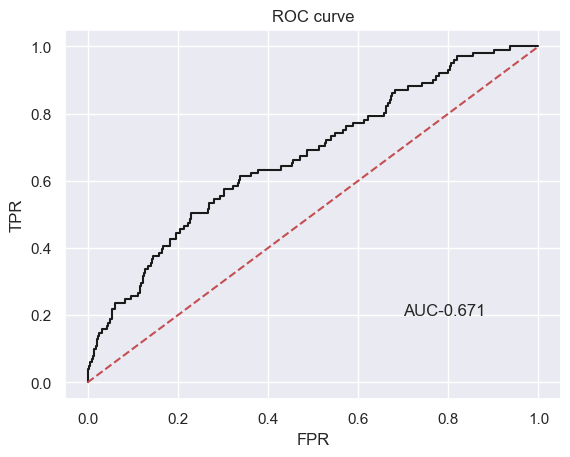

In [20]:
y_pred = LogReg.predict(X_test)
y_prob = LogReg.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(LogReg.score(X_test, y_test))

# parameters for plotting the ROC curve
fpr, tpr, th = roc_curve(y_test, y_prob[:,1])
auc = roc_auc_score(y_test, y_prob[:,1])

plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
plt.title('ROC curve')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(0.7,0.2,'AUC-'+"{:.3f}".format(auc))

In [21]:
def gen_logistic(x, w=1, b=0):
    """
    outputing the logistic output for an input x
    :param x: scalar or numpy array of shape (n_samples, n_features). If only one feature, it must have the shape of (n_samples,1).
    :param w: weight(s); either scalar or numpy array of shape (1, n_features)
    :param b: bias; either scalar or numpy array of shape (1,)
    returns y of shape (n_samples,)
    """    
    y =0 
    if np.isscalar(x):
        x = np.array(x).reshape((1,1))
    if np.isscalar(w):
        w = np.array(w).reshape((1,1))
    if np.isscalar(b):
        b = np.array(b).reshape((1,1))  
    if b.shape==(1,):
        b= b.reshape((1,1))  
        
    z = np.dot(x, w.T) + b
    z = z.astype(float)
    
    y = 1 / (1 + np.exp(-z))
    
    #print(y)
    #print(y.reshape(y.shape[0],))
    return y.reshape(y.shape[0],)


def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates precision for a binary classifier.
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    precision = 0.0
    TP = np.sum((y_true == pos_label_value) & (y_pred == pos_label_value))
    FP = np.sum((y_true != pos_label_value) & (y_pred == pos_label_value))
    
    if TP + FP == 0:
        precision = 1.0
    else:
        precision = TP / (TP + FP)
    
    return precision


def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates recall for a binary classifier.
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    recall = 0.0
    TP = np.sum((y_true == pos_label_value) & (y_pred == pos_label_value))
    FN = np.sum((y_true == pos_label_value) & (y_pred != pos_label_value))
    
    if TP + FN == 0:
        recall = 1.0
    else:
        recall = TP / (TP + FN)
        
    return recall



In [22]:
y_pred = 0
# model coefficients
w = LogReg.coef_
b = LogReg.intercept_

y_pred_prob = gen_logistic(X_test, w, b)
y_pred = y_pred_prob > 0.5 

precision = calculate_precision(y_test, y_pred)
recall = calculate_recall(y_test, y_pred)

print('Model Precision : %0.2f' % precision)
print('Model Recall : %0.2f' % recall)


Model Precision : 1.00
Model Recall : 0.00


In [23]:
# Balanced forest

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)

print(balanced_accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report_imbalanced(y_test, y_pred))



0.7665611772823682
[[15215  1889]
 [   36    65]]
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.89      0.64      0.94      0.76      0.59     17104
          1       0.03      0.64      0.89      0.06      0.76      0.56       101

avg / total       0.99      0.89      0.65      0.94      0.76      0.59     17205



In [24]:
# features by descending importance
sorted(zip(brf.feature_importances_, X_train.columns), reverse=True)


[(0.08200603138527934, 'total_rec_prncp'),
 (0.06396934747748335, 'total_pymnt_inv'),
 (0.05744347415935885, 'total_rec_int'),
 (0.05059089525220024, 'total_pymnt'),
 (0.04957836333074211, 'last_pymnt_amnt'),
 (0.03313864789639978, 'int_rate'),
 (0.02047701317088599, 'issue_d_Jan-2019'),
 (0.0193697462184253, 'installment'),
 (0.017439180890896647, 'out_prncp_inv'),
 (0.016900289617929845, 'tot_hi_cred_lim'),
 (0.016779159090776104, 'dti'),
 (0.015918154332127777, 'mths_since_rcnt_il'),
 (0.015730979750990595, 'annual_inc'),
 (0.015019425852185124, 'total_bc_limit'),
 (0.014632588232213887, 'mo_sin_old_il_acct'),
 (0.014531434631017947, 'avg_cur_bal'),
 (0.014476697543636563, 'mths_since_recent_inq'),
 (0.014297199923957386, 'bc_util'),
 (0.014065599151397613, 'il_util'),
 (0.01372024744521318, 'max_bal_bc'),
 (0.013672087318338818, 'tot_cur_bal'),
 (0.013640477255942788, 'total_rev_hi_lim'),
 (0.01358415277298156, 'loan_amnt'),
 (0.013197281637035508, 'mo_sin_old_rev_tl_op'),
 (0.0131

In [25]:
# AdaBoost Classifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1 )
eec.fit(X_train, y_train)

print(Counter(y_train))

y_pred = eec.predict(X_test)

print(balanced_accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report_imbalanced(y_test, y_pred))

Counter({0: 51366, 1: 246})
0.8724497888282747
[[15789  1315]
 [   18    83]]
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.92      0.82      0.96      0.87      0.77     17104
          1       0.06      0.82      0.92      0.11      0.87      0.75       101

avg / total       0.99      0.92      0.82      0.95      0.87      0.77     17205



In [26]:
# Decision tree X and y are all float or bool here

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(random_state=0)

[Text(0.28480940278741085, 0.9838709677419355, 'x[16] <= 1.91\ngini = 0.01\nsamples = 68817\nvalue = [68470, 347]'),
 Text(0.07291073317601107, 0.9516129032258065, 'x[85] <= 0.5\ngini = 0.42\nsamples = 180\nvalue = [54, 126]'),
 Text(0.06770282366343884, 0.9193548387096774, 'gini = 0.0\nsamples = 81\nvalue = [0, 81]'),
 Text(0.07811864268858329, 0.9193548387096774, 'x[62] <= 9.5\ngini = 0.496\nsamples = 99\nvalue = [54, 45]'),
 Text(0.07291073317601107, 0.8870967741935484, 'x[54] <= 0.5\ngini = 0.5\nsamples = 90\nvalue = [45, 45]'),
 Text(0.05207909512572219, 0.8548387096774194, 'x[30] <= 23.5\ngini = 0.487\nsamples = 69\nvalue = [40, 29]'),
 Text(0.036455366588005536, 0.8225806451612904, 'x[58] <= 1.5\ngini = 0.452\nsamples = 58\nvalue = [38, 20]'),
 Text(0.031247457075433315, 0.7903225806451613, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.041663276100577754, 0.7903225806451613, 'x[36] <= 88.5\ngini = 0.427\nsamples = 55\nvalue = [38, 17]'),
 Text(0.036455366588005536, 0.75806

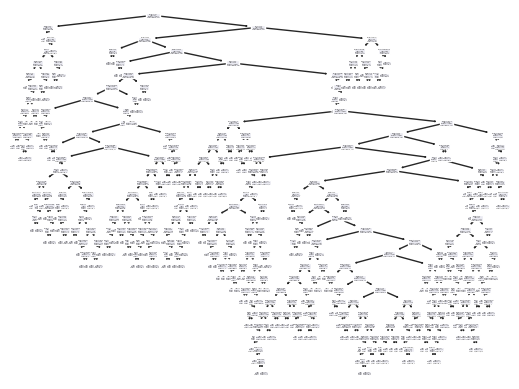

In [27]:
tree.plot_tree(clf.fit(X,y))

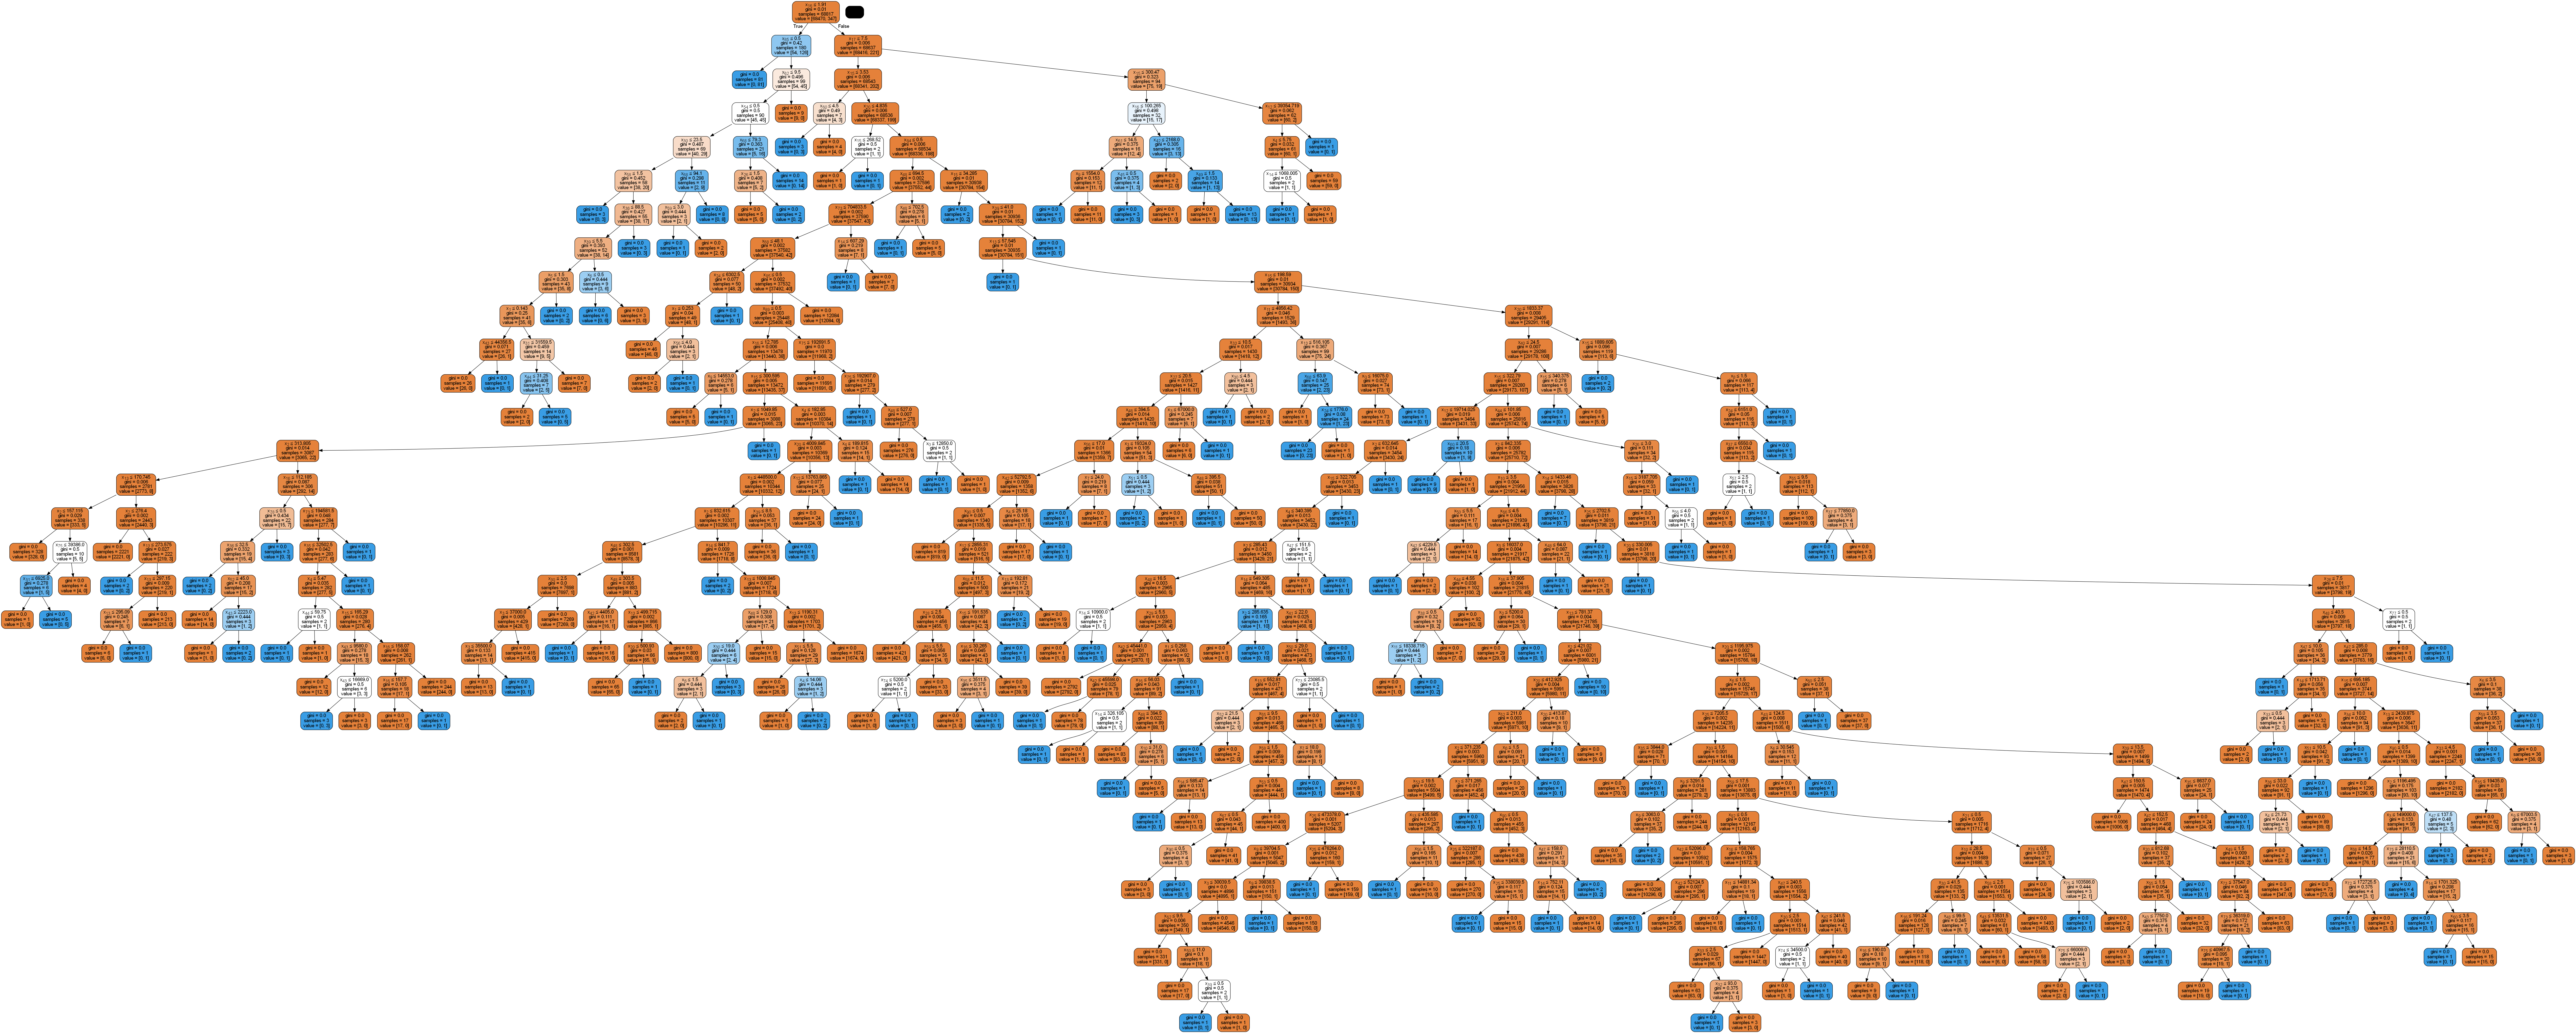

In [29]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [30]:
# DT max depth = 2
clf = DecisionTreeClassifier(max_depth = 2, random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

[Text(0.5, 0.8333333333333334, 'x[16] <= 1.91\ngini = 0.01\nsamples = 68817\nvalue = [68470, 347]'),
 Text(0.25, 0.5, 'x[85] <= 0.5\ngini = 0.42\nsamples = 180\nvalue = [54, 126]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 81\nvalue = [0, 81]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.496\nsamples = 99\nvalue = [54, 45]'),
 Text(0.75, 0.5, 'x[17] <= 7.5\ngini = 0.006\nsamples = 68637\nvalue = [68416, 221]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.006\nsamples = 68543\nvalue = [68341, 202]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.323\nsamples = 94\nvalue = [75, 19]')]

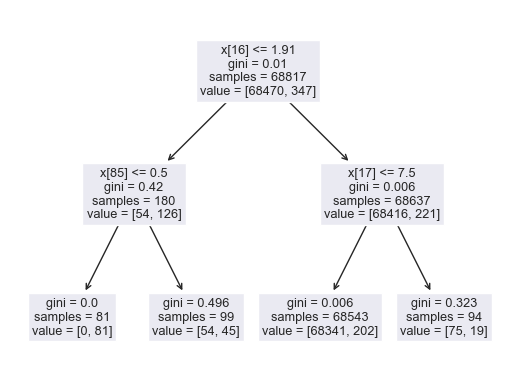

In [31]:
tree.plot_tree(clf.fit(X,y))

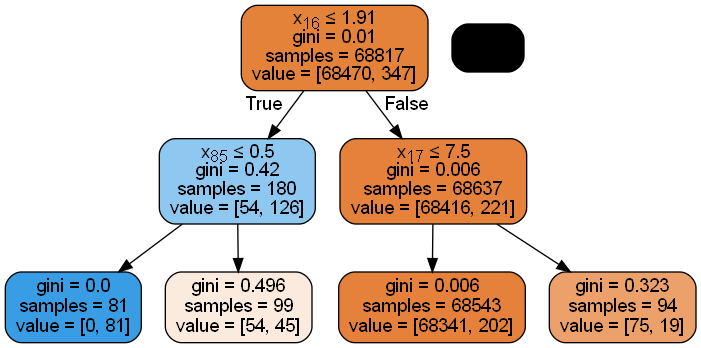

In [32]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [34]:
rf = DecisionTreeClassifier()
parameters = {'max_depth': [1,2,3,5,7,10,15,20,25,30], 'min_samples_leaf': [1,2,5,10]}
clfg = GridSearchCV(rf, parameters)
clfg.fit(X,y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 5, 7, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10]})

In [35]:
clfg.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10)

In [36]:
clfg.best_score_

0.9961346724302803

In [62]:
#using the max depth 7 and min sample leafs 10 new DT
clf = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 10, random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, random_state=0)

[Text(0.48828125, 0.9375, 'x[16] <= 1.91\ngini = 0.01\nsamples = 68817\nvalue = [68470, 347]'),
 Text(0.2578125, 0.8125, 'x[85] <= 0.5\ngini = 0.42\nsamples = 180\nvalue = [54, 126]'),
 Text(0.2265625, 0.6875, 'gini = 0.0\nsamples = 81\nvalue = [0, 81]'),
 Text(0.2890625, 0.6875, 'x[36] <= 71.5\ngini = 0.496\nsamples = 99\nvalue = [54, 45]'),
 Text(0.203125, 0.5625, 'x[31] <= 41777.5\ngini = 0.468\nsamples = 75\nvalue = [47, 28]'),
 Text(0.125, 0.4375, 'x[1] <= 0.137\ngini = 0.5\nsamples = 51\nvalue = [26, 25]'),
 Text(0.0625, 0.3125, 'x[41] <= 3.5\ngini = 0.437\nsamples = 31\nvalue = [21, 10]'),
 Text(0.03125, 0.1875, 'gini = 0.463\nsamples = 11\nvalue = [4, 7]'),
 Text(0.09375, 0.1875, 'x[35] <= 3898.5\ngini = 0.255\nsamples = 20\nvalue = [17, 3]'),
 Text(0.0625, 0.0625, 'gini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(0.125, 0.0625, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.1875, 0.3125, 'x[30] <= 8.0\ngini = 0.375\nsamples = 20\nvalue = [5, 15]'),
 Text(0.15625, 0.18

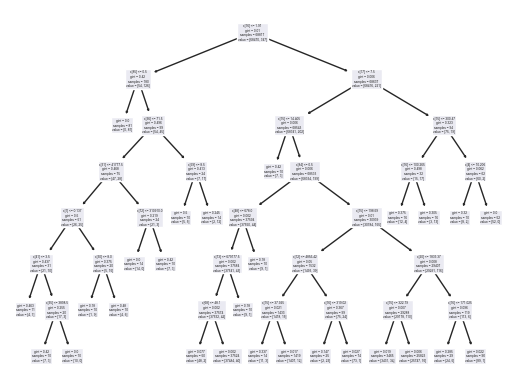

In [63]:
tree.plot_tree(clf.fit(X,y))

[Text(0.48828125, 0.9375, 'total_rec_int <= 1.91\ngini = 0.01\nsamples = 68817\nvalue = [68470, 347]\nclass = low_risk'),
 Text(0.2578125, 0.8125, 'issue_d_Mar-2019 <= 0.5\ngini = 0.42\nsamples = 180\nvalue = [54, 126]\nclass = high_risk'),
 Text(0.2265625, 0.6875, 'gini = 0.0\nsamples = 81\nvalue = [0, 81]\nclass = high_risk'),
 Text(0.2890625, 0.6875, 'all_util <= 71.5\ngini = 0.496\nsamples = 99\nvalue = [54, 45]\nclass = low_risk'),
 Text(0.203125, 0.5625, 'total_bal_il <= 41777.5\ngini = 0.468\nsamples = 75\nvalue = [47, 28]\nclass = low_risk'),
 Text(0.125, 0.4375, 'int_rate <= 0.137\ngini = 0.5\nsamples = 51\nvalue = [26, 25]\nclass = low_risk'),
 Text(0.0625, 0.3125, 'acc_open_past_24mths <= 3.5\ngini = 0.437\nsamples = 31\nvalue = [21, 10]\nclass = low_risk'),
 Text(0.03125, 0.1875, 'gini = 0.463\nsamples = 11\nvalue = [4, 7]\nclass = high_risk'),
 Text(0.09375, 0.1875, 'max_bal_bc <= 3898.5\ngini = 0.255\nsamples = 20\nvalue = [17, 3]\nclass = low_risk'),
 Text(0.0625, 0.0625

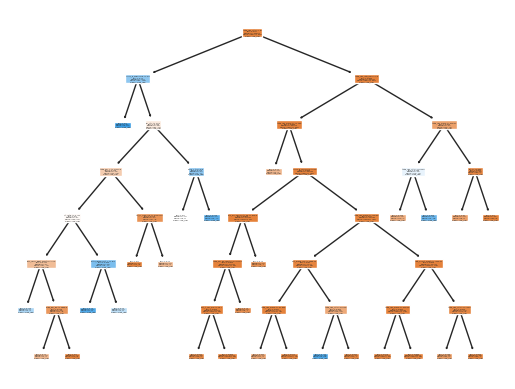

In [64]:
features = list(X.columns)
target_vals = ['low_risk', 'high_risk']
tree.plot_tree(clf.fit(X,y), feature_names=features, class_names=target_vals, filled=True)

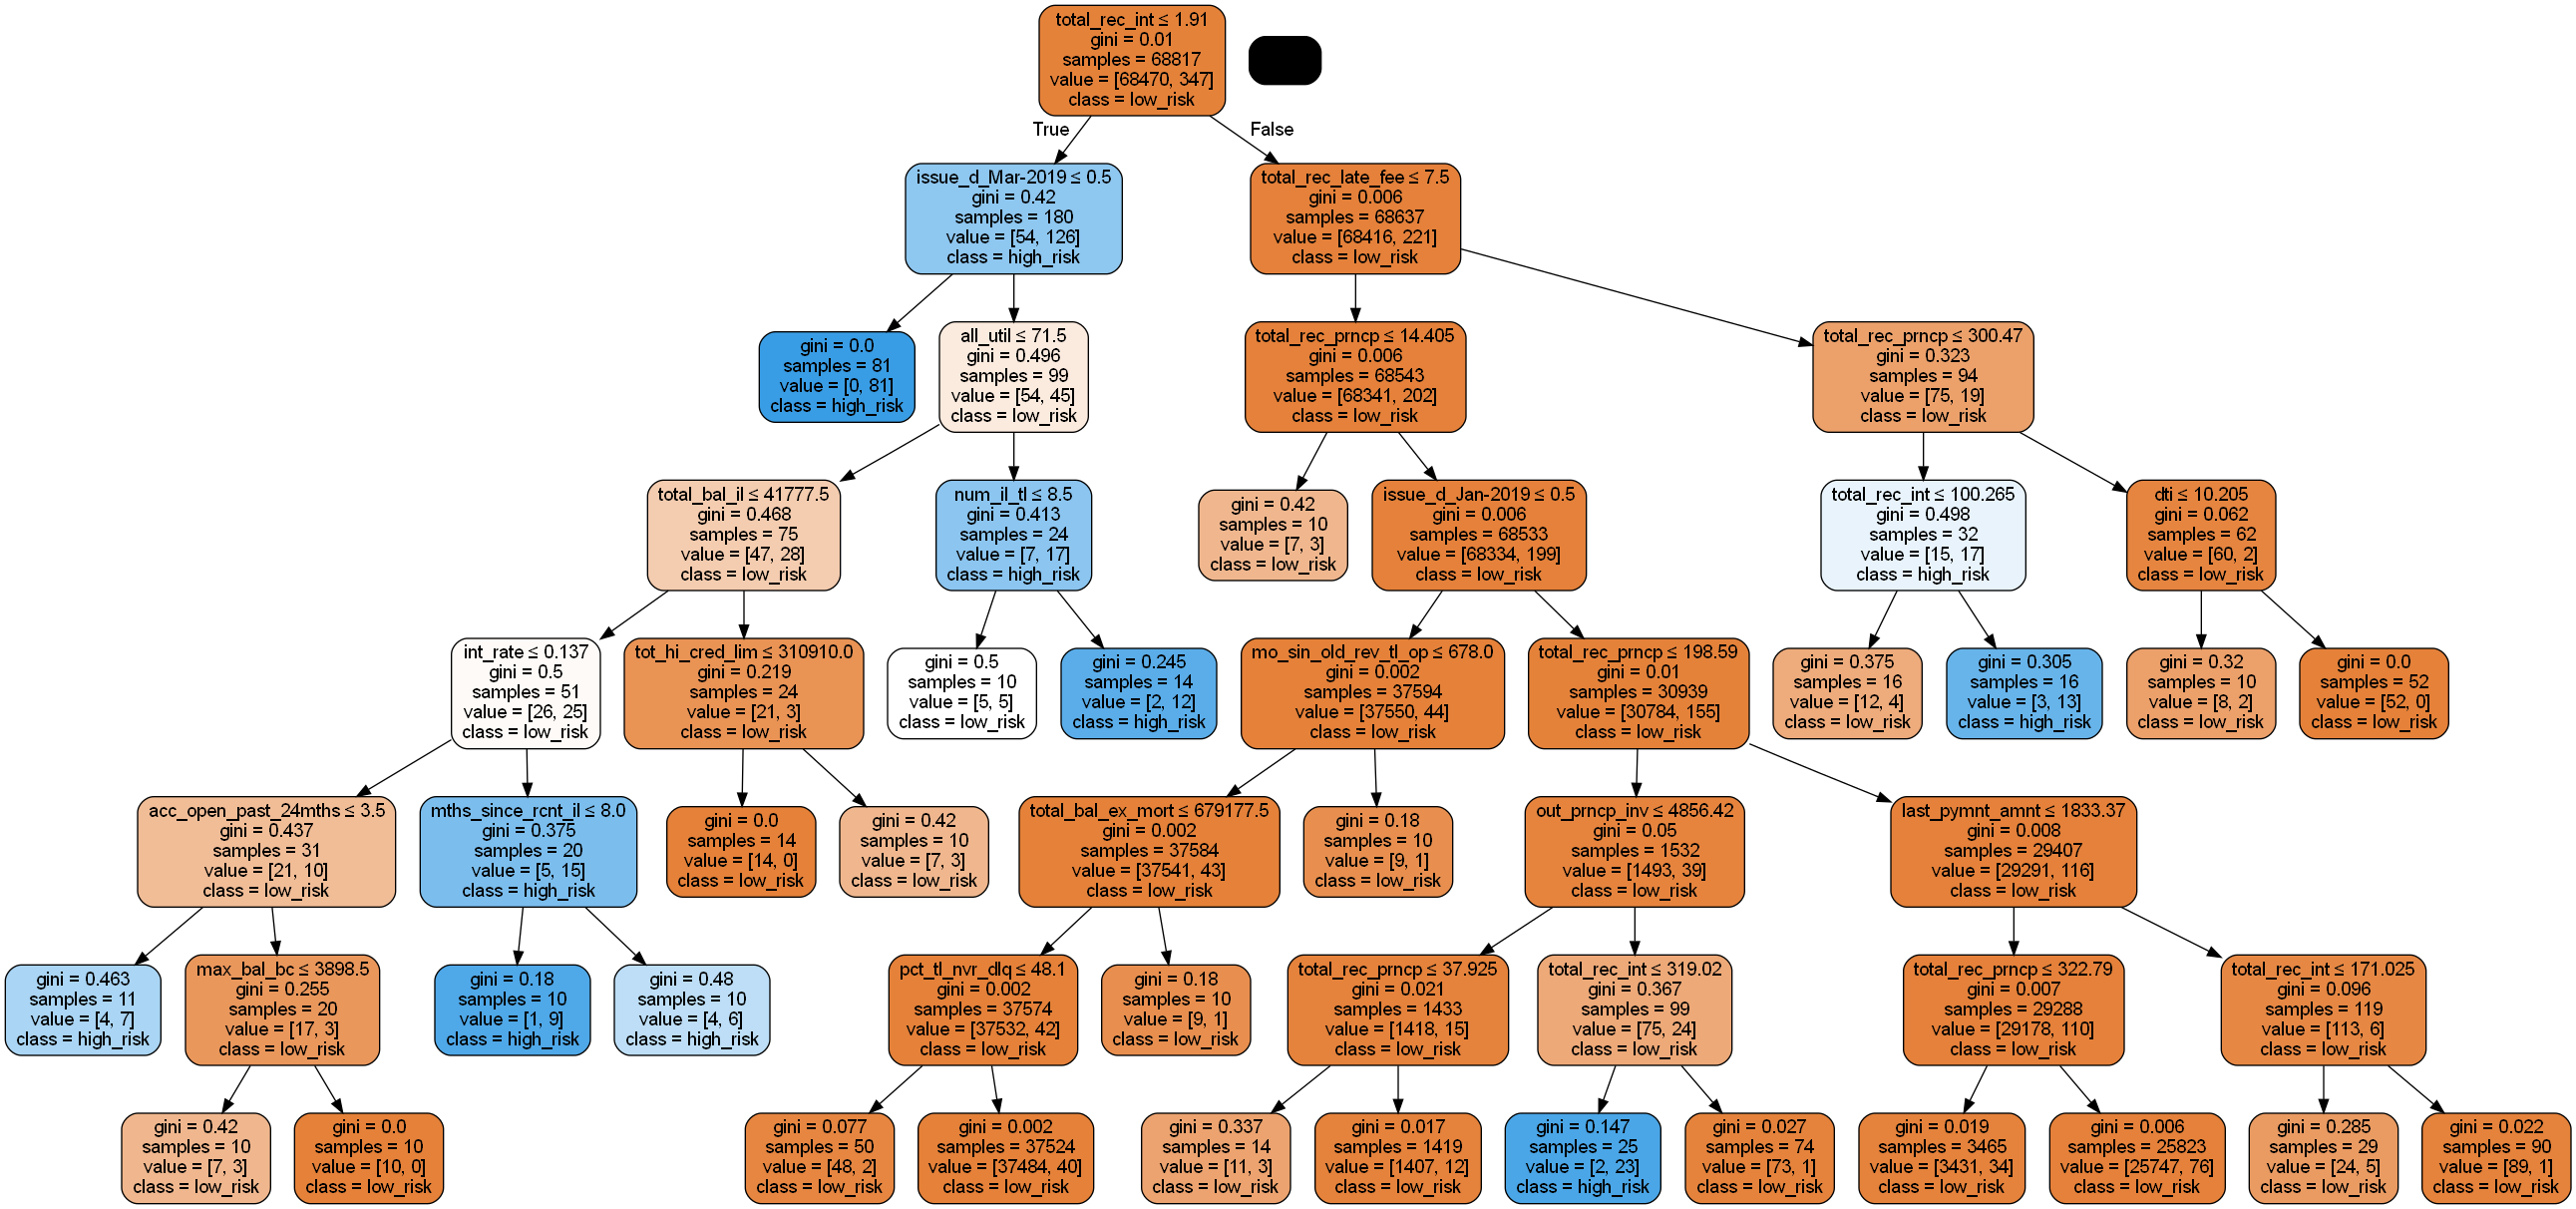

In [42]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True,
               feature_names=features, class_names=target_vals)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

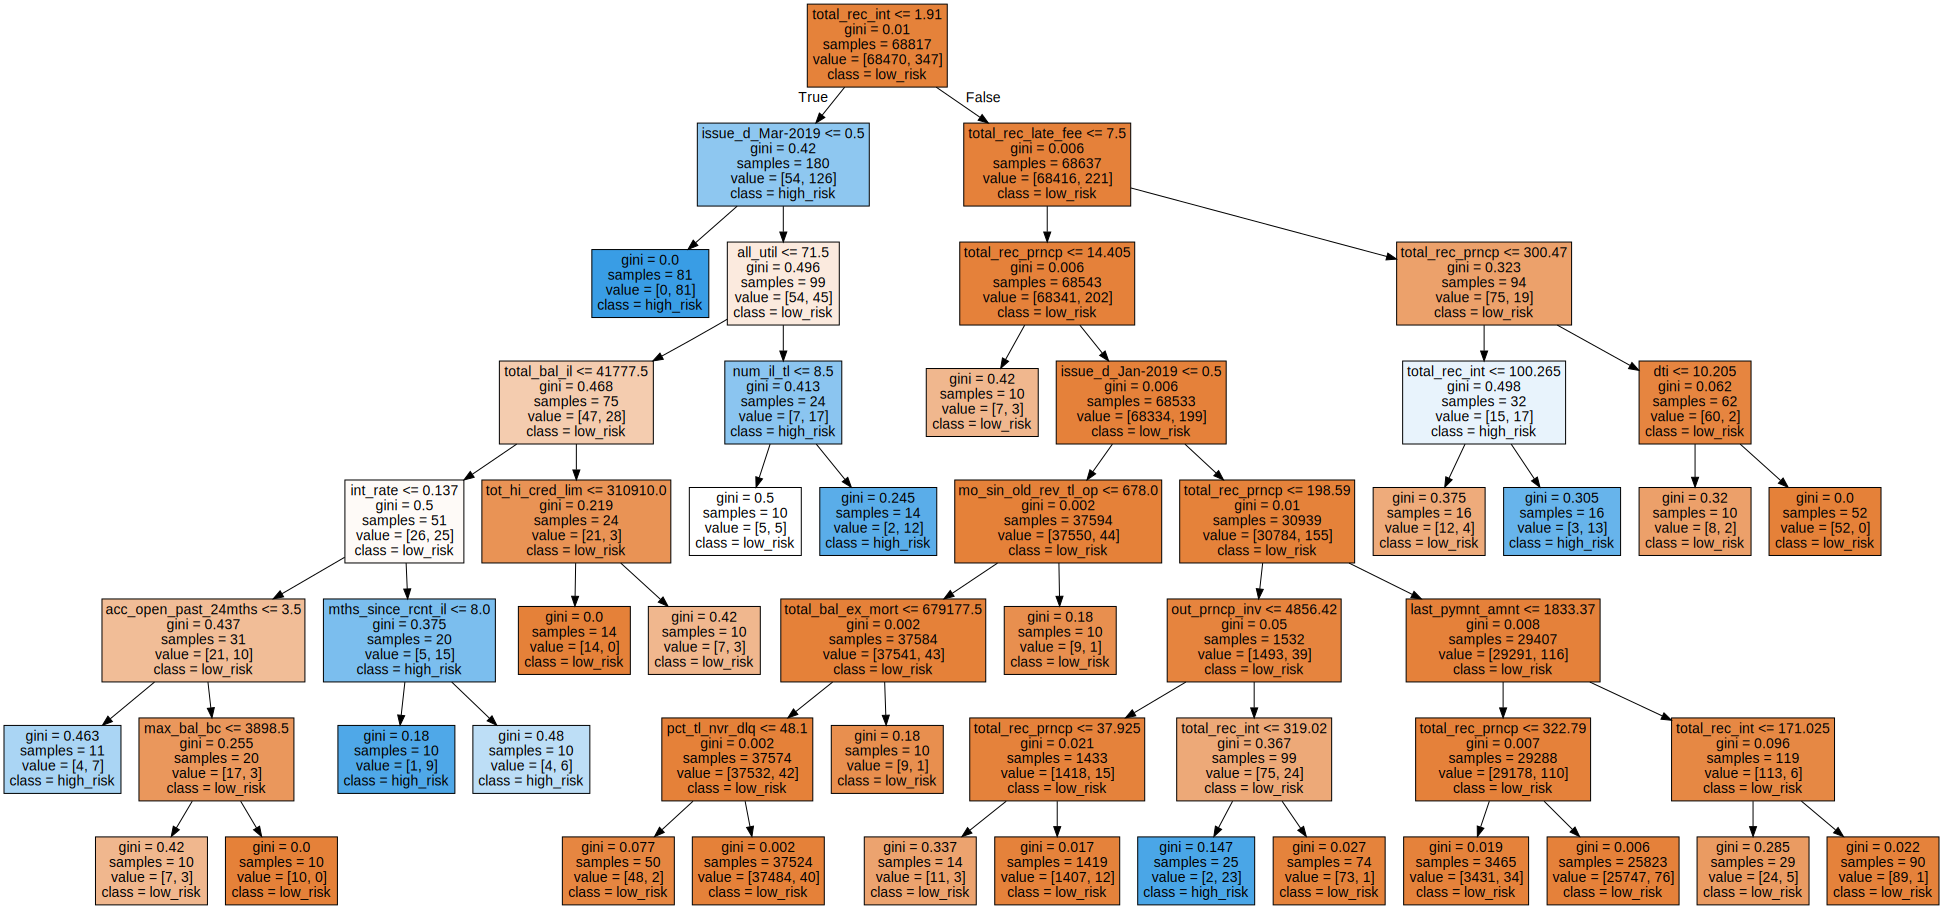

In [49]:
dot_data = tree.export_graphviz(clf.fit(X,y), out_file=None, 
                                feature_names=features, class_names=target_vals, filled=True)
graphdraw = graphviz.Source(dot_data, format="png")
graphdraw

In [51]:
graphdraw.render("final_decision_tree")

'final_decision_tree.png'

In [52]:
# Decision tree regressor
# previous bests  max_depth = 7, min_samples_leaf = 10
# finding bests to see if they match
rf = DecisionTreeRegressor(random_state=1234)
parameters = {'max_depth': [1,2,3,5,7,10,15,20,25,30], 'min_samples_leaf': [1,2,5,10]}
clfg = GridSearchCV(rf, parameters)
clfg.fit(X,y)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=1234),
             param_grid={'max_depth': [1, 2, 3, 5, 7, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10]})

In [53]:
clfg.best_estimator_

DecisionTreeRegressor(max_depth=3, random_state=1234)

In [54]:
clfg.best_score_

0.3062235530313728

In [55]:
#using the max depth 3 and random_state=1234
clf = DecisionTreeRegressor(max_depth = 3, random_state=1234)
clf.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=1234)

[Text(0.4230769230769231, 0.875, 'total_rec_int <= 1.91\nsquared_error = 0.005\nsamples = 68817\nvalue = 0.005'),
 Text(0.15384615384615385, 0.625, 'issue_d_Mar-2019 <= 0.5\nsquared_error = 0.21\nsamples = 180\nvalue = 0.7'),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 81\nvalue = 1.0'),
 Text(0.23076923076923078, 0.375, 'num_actv_rev_tl <= 9.5\nsquared_error = 0.248\nsamples = 99\nvalue = 0.455'),
 Text(0.15384615384615385, 0.125, 'squared_error = 0.25\nsamples = 90\nvalue = 0.5'),
 Text(0.3076923076923077, 0.125, 'squared_error = 0.0\nsamples = 9\nvalue = 0.0'),
 Text(0.6923076923076923, 0.625, 'total_rec_late_fee <= 7.5\nsquared_error = 0.003\nsamples = 68637\nvalue = 0.003'),
 Text(0.5384615384615384, 0.375, 'total_rec_prncp <= 3.53\nsquared_error = 0.003\nsamples = 68543\nvalue = 0.003'),
 Text(0.46153846153846156, 0.125, 'squared_error = 0.245\nsamples = 7\nvalue = 0.429'),
 Text(0.6153846153846154, 0.125, 'squared_error = 0.003\nsamples = 68536\nvalue = 0.0

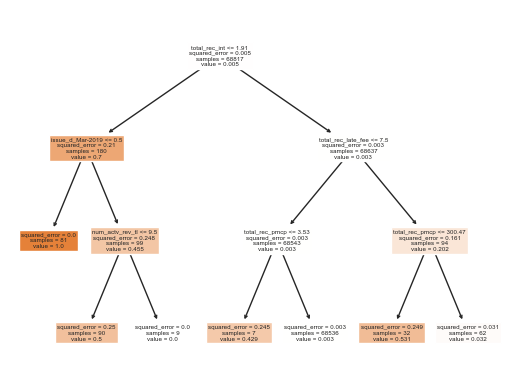

In [56]:
features = list(X.columns)
target_vals = ['low_risk', 'high_risk']
tree.plot_tree(clf.fit(X,y), feature_names=features, class_names=target_vals, filled=True)

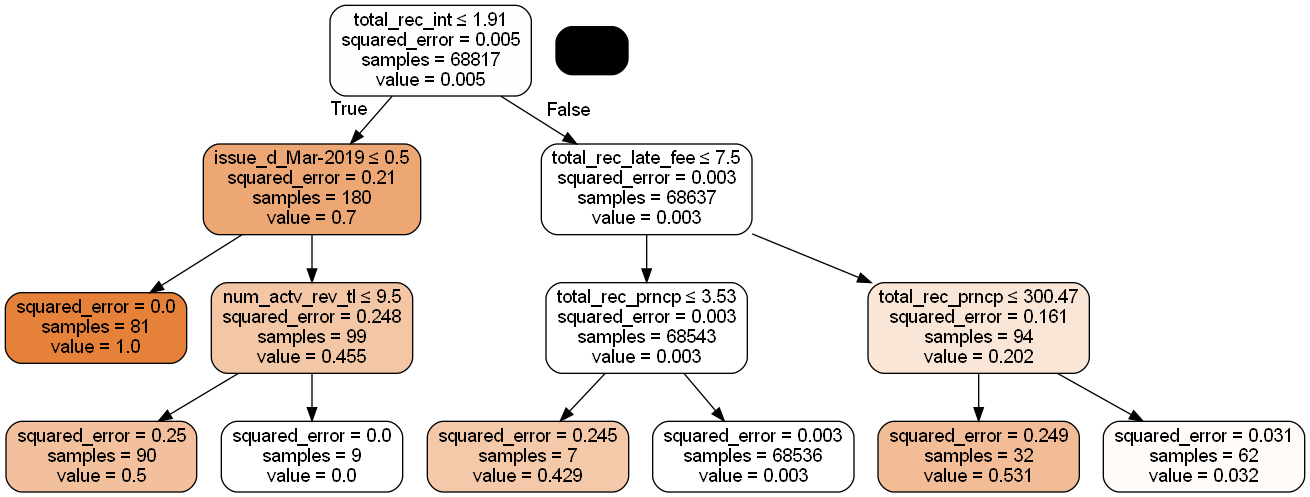

In [57]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True,
               feature_names=features, class_names=target_vals)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

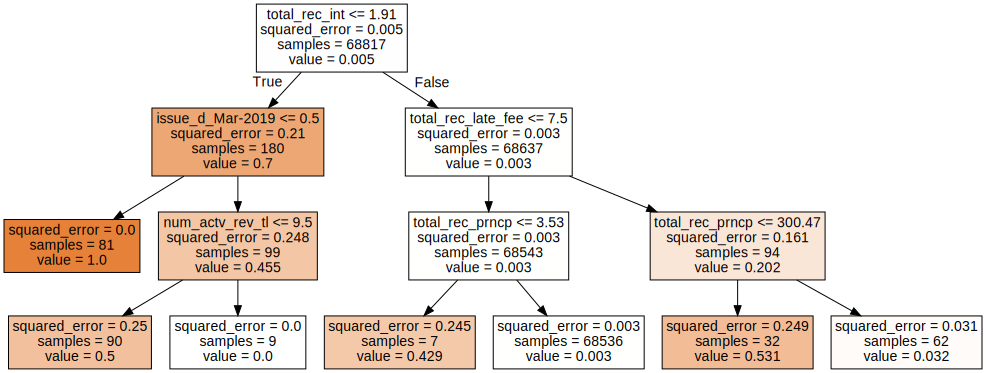

In [58]:
dot_data = tree.export_graphviz(clf.fit(X,y), out_file=None, 
                                feature_names=features, class_names=target_vals, filled=True)
graphdraw = graphviz.Source(dot_data, format="png")
graphdraw

In [59]:
graphdraw.render("final_decision_tree_regr")

'final_decision_tree_regr.png'

In [93]:
# best features
# DT depth=7	feature-names	brf feature importance
# x[16]	total_rec_int	0.05744347415935885
# x[85]	issue_d_Mar-2019	0.01260405402182236
# x[36]	all_util	0.01262996265448217
# x[31]	total_bal_il	0.012430781568428943
# x[1]	loan_amnt	0.01358415277298156
# x[41]	acc_open_past_24mths	0.009995869089887153
# x[35]	max_bal_bc	0.01372024744521318
# x[30]	mths_since_rcnt_il	0.015918154332127777
# x[72]	tot_hi_cred_lim	0.016900289617929845
# x[59]	num_il_tl	0.008092083494194737
# x[17]	total_rec_late_fee	0.008655528380048605
# x[15]	total_rec_prncp	0.08200603138527934
# x[84]	issue_d_Jan-2019	0.02047701317088599
# x[48]	mo_sin_old_rev_tl_op	0.013197281637035508
# x[73]	total_bal_ex_mort	0.009745872368192873
# x[68]	pct_tl_nvr_dlq	0.008450971243299408
# x[12]	out_prncp_inv	0.017439180890896647
# x[20]	last_pymnt_amnt	0.04957836333074211
# x[4]	dti	0.016779159090776104

# 'total_rec_int', 'issue_d_Mar-2019', 'all_util', 'total_bal_il', 'loan_amnt', 'acc_open_past_24mths',
# 'max_bal_bc', 'mths_since_rcnt_il', 'tot_hi_cred_lim', 'num_il_tl', 'total_rec_late_fee',
# 'total_rec_prncp', 'issue_d_Jan-2019', 'mo_sin_old_rev_tl_op', 'total_bal_ex_mort', 'pct_tl_nvr_dlq',
# 'out_prncp_inv', 'last_pymnt_amnt', 'dti',
#

# X1 has all data still

allow_factors = ['total_rec_int', 'issue_d_Mar_2019', 'all_util', 'total_bal_il', 'loan_amnt', 
                 'acc_open_past_24mths', 'max_bal_bc', 'mths_since_rcnt_il', 'tot_hi_cred_lim', 
                 'num_il_tl', 'total_rec_late_fee', 'total_rec_prncp', 'issue_d_Jan_2019', 
                 'mo_sin_old_rev_tl_op', 'total_bal_ex_mort', 'pct_tl_nvr_dlq', 'out_prncp_inv',
                 'last_pymnt_amnt', 'dti']


X2['issue_d_Jan-2019'] = X2['issue_d_Jan-2019'].map({True: 1, False: 0})
X2['issue_d_Mar-2019'] = X2['issue_d_Mar-2019'].map({True: 1, False: 0})

X2.rename(columns={'issue_d_Mar-2019': 'issue_d_Mar_2019', 
                  'issue_d_Jan-2019': 'issue_d_Jan_2019',}, 
         inplace=True)

X_train, X_test = train_test_split(X2, random_state=0, test_size=0.25, shuffle=True)

In [95]:
best = ['',0]
for p in allow_factors:
    model  = smf.ols(formula='loan_status~'+p, data=X_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

total_rec_int 0.0011277878525245422
issue_d_Mar_2019 3.906613971194073e-05
all_util 7.274929079237324e-05
total_bal_il 3.9527432169728094e-05
loan_amnt 4.981342448751036e-06
acc_open_past_24mths 0.00011829002943786193
max_bal_bc 0.00018359388565414303
mths_since_rcnt_il 3.657741600515685e-05
tot_hi_cred_lim 5.025980133110952e-05
num_il_tl 6.875640459036436e-05
total_rec_late_fee 0.005022129235007666
total_rec_prncp 3.7318400388564044e-05
issue_d_Jan_2019 0.000246863675453568
mo_sin_old_rev_tl_op 7.738068559692834e-06
total_bal_ex_mort 3.079516565784868e-05
pct_tl_nvr_dlq 8.22569337644019e-06
out_prncp_inv 2.5153341978167987e-06
last_pymnt_amnt 6.0486411366134085e-05
dti 5.444817036459604e-06
best: ['total_rec_late_fee', 0.005022129235007666]


In [94]:
X2['issue_d_Mar_2019'].unique()


array([1, 0], dtype=int64)

In [96]:
formulaP = f'loan_status~'
i = 0
for factor in allow_factors:
    factor = factor.strip()
    if i == 0:
        formulaP += f'{factor}'
    else:
        formulaP += f'+{factor}'
    i += 1

print(formulaP)

loan_status~total_rec_int+issue_d_Mar_2019+all_util+total_bal_il+loan_amnt+acc_open_past_24mths+max_bal_bc+mths_since_rcnt_il+tot_hi_cred_lim+num_il_tl+total_rec_late_fee+total_rec_prncp+issue_d_Jan_2019+mo_sin_old_rev_tl_op+total_bal_ex_mort+pct_tl_nvr_dlq+out_prncp_inv+last_pymnt_amnt+dti


In [97]:
model  = smf.ols(formula=formulaP, data=X_train).fit()
print(model.rsquared)

print(model.summary())

0.010402589380905547
                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     28.54
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          2.69e-102
Time:                        14:07:50   Log-Likelihood:                 63406.
No. Observations:               51612   AIC:                        -1.268e+05
Df Residuals:                   51592   BIC:                        -1.266e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept  